# PageRank Algorithm with Neptune Analytics

This notebook demonstrates how the PageRank algorithm computation can be offloaded to a remote AWS Neptune Analytics instance. We'll compare the results between local NetworkX execution and Neptune Analytics execution.

## Setup and Imports

First, let's import the necessary libraries and set up logging.

In [1]:
import networkx as nx
from nx_neptune import NeptuneGraph
from nx_neptune.clients import Node, Edge
import logging
import os
import sys
import matplotlib.pyplot as plt

In [18]:
# Configure logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Reduce verbosity for some loggers
for logger_name in ['boto3', 'botocore', 'urllib3', 'matplotlib', 'networkx', 'nx_neptune.interface',
                    'nx_neptune.clients.na_client',
                    'nx_neptune.algorithms.link_analysis.pagerank']:
    logging.getLogger(logger_name).setLevel(logging.WARNING)
    
logger = logging.getLogger(__name__)

# Ignore cache warnings
nx.config.warnings_to_ignore.add("cache")

## Check for Neptune Analytics Graph ID

We need to ensure that the GRAPH_ID environment variable is set. You can also set it directly in this notebook.

In [14]:
# Read and load graphId from environment variable
graph_id = os.getenv('GRAPH_ID')

# If not set, you can set it here
if not graph_id:
    # Uncomment and set your Graph ID
    # %env GRAPH_ID=your-neptune-analytics-graph-id
    # graph_id = os.getenv('GRAPH_ID')
    print("Warning: Environment Variable GRAPH_ID is not defined")
    print("You can set it using: %env GRAPH_ID=your-neptune-analytics-graph-id")
else:
    print(f"Using Neptune Analytics Graph ID: {graph_id}")

Using Neptune Analytics Graph ID: g-r4g1koz7v9


## Clear the Neptune Analytics Graph

Let's start with a clean slate by clearing any existing data in the Neptune Analytics graph.

In [ ]:
# Clear the Neptune Analytics graph
g = nx.Graph()
na_graph = NeptuneGraph(graph=g)
na_graph.clear_graph()
print("Neptune Analytics graph cleared successfully")

## Create and Visualize the Graph

Let's create a directed graph with a specific structure for our PageRank demonstration.

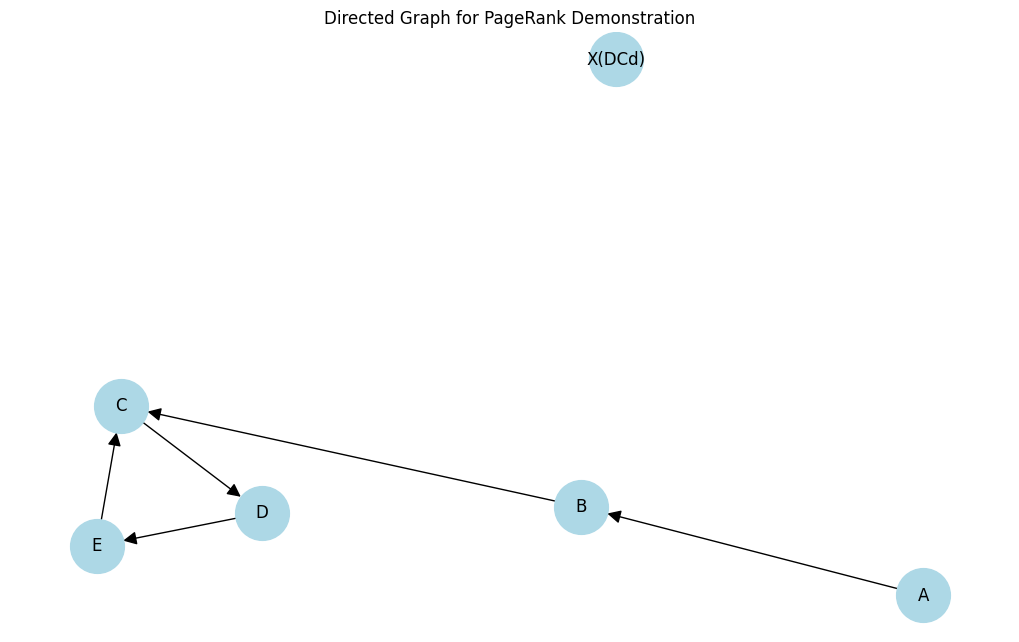

Graph structure:

   A→B→C→D→E
       ↑   |
       └───┘

   X(DCd)



In [19]:
# Create a directed graph
g = nx.DiGraph()

# Clean up remote graph and populate test data
na_graph = NeptuneGraph(graph=g)
na_graph.clear_graph()

# Test data - explicitly defining the graph with alphabetical nodes and directed edges
# Add nodes
nodes = ['A', 'B', 'C', 'D', 'E']
g.add_nodes_from(nodes)

# Add directed edges to create a directed path graph (A→B→C→D→E)
g.add_edge('A', 'B')
g.add_edge('B', 'C')
g.add_edge('C', 'D')
g.add_edge('D', 'E')

# Add a cycle by connecting E back to C
g.add_edge('E', 'C')

# Add an isolated node
g.add_node("X(DCd)")

# Visualize the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(g, seed=42)
nx.draw(g, pos, with_labels=True, node_color='lightblue', 
        node_size=1500, font_size=12, arrows=True, arrowsize=20)
plt.title("Directed Graph for PageRank Demonstration")
plt.show()

print("Graph structure:")
print("""
   A→B→C→D→E
       ↑   |
       └───┘

   X(DCd)
""")

## Run PageRank with Standard NetworkX

First, let's run the PageRank algorithm using the standard NetworkX implementation.

In [16]:
# Scenario: Local execution
r_local = nx.pagerank(g)
print("PageRank results using standard NetworkX:")
for key, value in sorted(r_local.items(), key=lambda x: (x[1], x[0]), reverse=True):
    print(f"{key}: {value:.6f}")

PageRank results using standard NetworkX:
C: 0.312870
D: 0.295065
E: 0.279930
B: 0.053883
X(DCd): 0.029126
A: 0.029126


## Run PageRank with Neptune Analytics

Now, let's run the same algorithm using Neptune Analytics as the backend.

In [20]:
# Scenario: AWS Neptune Analytics
try:
    r_neptune = nx.pagerank(g, backend="neptune")
    print("PageRank results using Neptune Analytics:")
    for key, value in sorted(r_neptune.items(), key=lambda x: (x[1], x[0]), reverse=True):
        print(f"{key}: {value:.6f}")
except Exception as e:
    print(f"Error: {e}")
    print("Make sure GRAPH_ID is set and your AWS credentials are configured correctly.")

WARNING - 'weight' parameter is not supported in Neptune Analytics implementation. This argument will be ignored and execution will proceed without it.


PageRank results using Neptune Analytics:
C: 0.315207
D: 0.296286
E: 0.276372
B: 0.053884
X(DCd): 0.029126
A: 0.029126


## Visualize PageRank Results

Let's visualize the PageRank results by adjusting the node sizes according to their PageRank values.

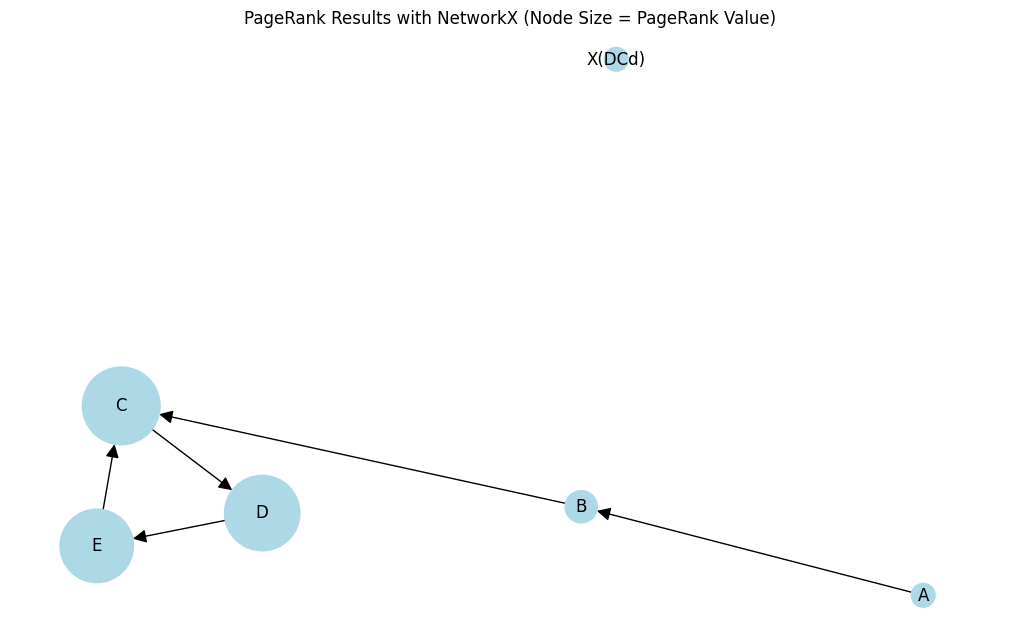

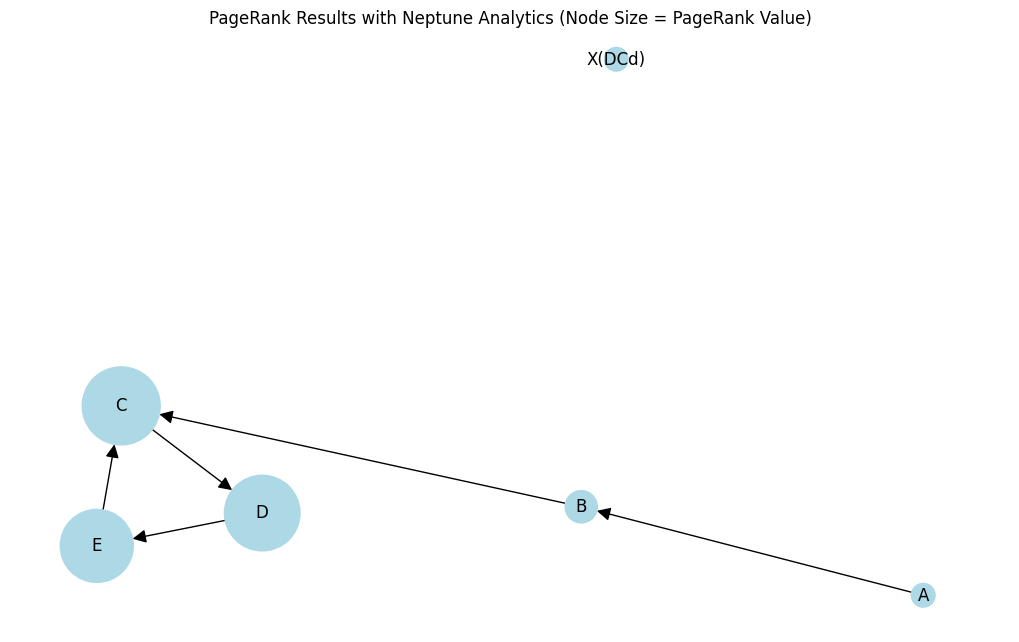

In [8]:
def visualize_pagerank(graph, pagerank_values, title):
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(graph, seed=42)
    
    # Scale node sizes based on PageRank values
    node_sizes = [pagerank_values[node] * 10000 for node in graph.nodes()]
    
    # Draw the graph
    nx.draw(graph, pos, with_labels=True, 
            node_color='lightblue', 
            node_size=node_sizes, 
            font_size=12, 
            arrows=True, 
            arrowsize=20)
    
    plt.title(title)
    plt.show()

# Visualize NetworkX PageRank results
visualize_pagerank(g, r_local, "PageRank Results with NetworkX (Node Size = PageRank Value)")

# Visualize Neptune Analytics PageRank results if available
try:
    visualize_pagerank(g, r_neptune, "PageRank Results with Neptune Analytics (Node Size = PageRank Value)")
except NameError:
    print("Cannot visualize Neptune Analytics results because execution failed.")

## Conclusion

This notebook demonstrated how to use the PageRank algorithm with both standard NetworkX and Neptune Analytics as a backend. The results show that:

1. Node C has the highest PageRank value, which makes sense as it receives links from both B and E
2. Nodes D and E also have high PageRank values due to being part of the cycle
3. The isolated node X(DCd) has a low PageRank value
4. There may be slight differences between the NetworkX and Neptune Analytics implementations

Using Neptune Analytics as a backend allows you to offload the computation to AWS, which can be beneficial for larger graphs where local computation would be resource-intensive.